In [1]:
using StatsBase
using CircularArrays
using LinearAlgebra
using Plots
using Random

In [2]:
#Define the parameters n, L(n), t, Ne(L)

n = 10
L = 8*n + 4
t = 1
Ne = Int(L / 2)

42

In [3]:
#Here we define the hamiltonian and the states - Lstate (length L with +1 -1 0 and 2 as occupancies)
#as well as the conversion between states from L to the extended one of 2L and viceversa

function Hamiltonian(L,t)
    H = zeros(2*L, 2*L)
    H[1,L] = -t
    H[L,1] = -t
    H[2L,L+1] = -t
    H[L+1,2L] = -t
    for i=1:2*L
      for j=1:2*L
        if i == j + 1 || i == j - 1
          H[i,j] = -t
        end 
      end
    end
    H[L,L+1]=0
    H[L+1,L]=0
    return H
end

H = Hamiltonian(L,t);


#generate, convert state
function Lstate(L)                                 #generate a state of length L
    Lstated, Lstateu, Lstate = zeros(L), zeros(L), zeros(L)
    randomposu = sample(collect(1:L), Int(L/4), replace=false)
    randomposd = sample(collect(1:L), Int(L/4), replace=false)
    for j in randomposu
        Lstateu[j] = 1
    end
    for j in randomposd
        Lstated[j] = -1
    end
    for i=1:L 
        if Lstated[i] == -1 && Lstateu[i] == 1
            Lstate[i] = 2
        else
            Lstate[i] = Lstated[i] + Lstateu[i]
        end
    end
    return CircularArray(Lstate)
end


function extendedstate(Lstatevector)               #take a state of length L and make it 2*L
    L = length(Lstatevector)
    State2L = zeros(2*L)
    for j=1:L
        if Lstatevector[j] == -1
            State2L[j + L] = 1
        elseif Lstatevector[j] == 1
            State2L[j] = 1
        elseif Lstatevector[j] == 2
            State2L[j], State2L[j + L] = 1,1
        else
            State2L[j] = 0
        end
    end
    return State2L
end


function shortstate(ext_state)                    #pass trom 2*L state to L state
    L = Int(length(ext_state)/2)
    sh_state = zeros(L)
    for j=1:L
        if ext_state[j]==1
            sh_state[j]=1
        end
    end
    for j=1:L
        if ext_state[L+j]==1
            if sh_state[j]==1
                sh_state[j]=2
            else
                sh_state[j]=-1
            end
        end
    end
    return sh_state
end

shortstate (generic function with 1 method)

In [25]:
#In this section we define functions to found the occupied and empty sites in our state and the move - hopping functions
#There are 3 options for the move, move_L and hopping makes a hop in vectors of length L and move_last_2L with ones  

#generate a move
function Pauli(x,i,j)                 #check if state i and j are both occupied
    if x[i] == 1 && x[j] == 1
        return true
    end
    return false
end 

function occupied_states(v)         #generate a vector with positions of occupied states (from 2*L states)
    occ_states = []
    L = length(v)
    for i = 1:L
        if v[i] == 1
            append!(occ_states, i)
        end
    end
    return occ_states
end


function occupied_states_L(v)
    occ_states = []
    L =length(v)
    for i = 1 : L
        if abs(v[i]) == 1
            append!(occ_states, i )
            
        elseif v[i] == 2
            append!(occ_states, i )
        
        end
    end
    return occ_states
end

function empty_states(v)
    empty_st_u = []
    empty_st_d = []
    L = length(v)
    for i = 1 : Int(L/2)
        if v[i] == 0
               append!(empty_st_u, i )
        end
    end
    for i = Int(L/2)+1 : L
        if v[i] == 0
               append!(empty_st_d, i )
        end
    end
    return empty_st_u, empty_st_d
end

function move_L(w)
    
   v = copy(w)
   i = rand(occupied_states_L(v))
   j = rand(-1:2:1)

    j_pbc = mod(i+j,L)
    j_pbc == 0 ? j_pbc = L : j_pbc = j_pbc

    if v[i] != v[j_pbc] && v[j_pbc]!=2

        if abs(v[i])==1
            v[j_pbc] == 0 ? v[j_pbc] = v[i] : v[j_pbc] = 2
            v[i] = 0

        elseif v[i]==2    
            spin = rand(-1:2:1)

        if v[j_pbc] != spin
           v[i] = -spin

        if abs(v[j_pbc]) == 1 
            v[j_pbc] = 2 
        elseif v[j_pbc] == 0 
            v[j_pbc] = spin 
        end

        end    
        end
            
    end

    return v
    
end

function move_last_2L(w)
    v = copy(w)
    L = length(v)
    i = rand(occupied_states(v))
    if i < L+1 
        j = rand(empty_states(v)[1])
        v[j] = v[i]
    else 
        j = rand(empty_states(v)[2])
    end
    v[i] = 0
    b = shortstate(v)
    return b
end

function hopping(v)
    w = copy(v)
    occupied_positions = occupied_states_L(v)
    i = rand(occupied_positions)
    nn = [v[i + 1],v[i - 1]]
    nnpos = [i + 1, i - 1]
    rndnnpos = rand([i + 1,i - 1])
    rndnn = rand(nn)
    
    if nn[1] == 2 && nn[2] == 2 || v[i] == 1 && nn[1] == 1 && nn[2] == 2 || v[i] == 1 && nn[1] == 2 && nn[2] == 1 || v[i] == 1 && nn[1] == 1 && nn[2] == 1 || v[i] == -1 && nn[1] == -1 && nn[2] == 2 || v[i] == -1 && nn[1] == 2 && nn[2] == -1 || v[i] == -1 && nn[1] == -1 && nn[2] == -1
        i = rand(deleteat!(occupied_positions, findall(x->x==i,occupied_positions)))
    end
    
    if v[i] == 1 && v[rndnnpos] == 1 || v[i] == 1 && v[rndnnpos] == 2
        rndnnpos = rand(deleteat!(nnpos, findall(x->x==rndnnpos, nnpos)))
    end
    
    if v[i] == -1 && v[rndnnpos] == -1 || v[i] == -1 && v[rndnnpos] == 2
        rndnnpos = rand(deleteat!(nnpos, findall(x->x==rndnnpos, nnpos)))
    end
    
    if v[i] == 2 && v[rndnnpos] == 2
        rndnnpos = rand(deleteat!(nnpos, findall(x->x==rndnnpos, nnpos)))
    end
     
    if v[i] == 1
        if v[rndnnpos] == -1
            w[i], w[rndnnpos] = 0, 2
        elseif v[rndnnpos] == 0
            w[i], w[rndnnpos] = 0, 1
        end
    
    elseif v[i] == -1 
        if v[rndnnpos] == 1
            w[i], w[rndnnpos] = 0, 2
        elseif v[rndnnpos] == 0
            w[i], w[rndnnpos] = 0, -1
        end
    
    elseif v[i] == 2
        if v[rndnnpos] == 1 
            w[i], w[rndnnpos] = 1, 2
        elseif v[rndnnpos] == -1
            w[i], w[rndnnpos] = -1,2
        elseif v[rndnnpos] == 0
            choosenspin = rand([1,-1])
            w[i], w[rndnnpos] = -1*choosenspin, choosenspin
        end
    end
    
    return w
end

hopping (generic function with 1 method)

In [5]:
#generate unitary matrices and the ratio of determinants

U = eigvecs(H)  #unitary matrix
Udag = inv(U)   #U^-1
E = eigvals(H)  #eigenvalues of H

function U1(A, Ne) #take the first Ne columns
    U_1 = A[:,1:Ne]
    return U_1
end

U_1 = U1(U,Ne)

function U_tilde(A,v)                  #takes just the rows related to occupied states, Ne*Ne matrix
    U_tild = []
    U_tild = A[occupied_states(v),:]
    return U_tild
end

function ratio_det(v, z)
    rat= det(U_tilde(U_1,z))/det(U_tilde(U_1,v))
    return rat
end  


ratio_det (generic function with 1 method)

In [6]:
#Jastrow factor
function n_i(vi)           #counts the number of els in positions vi, returning (# up , # down)
    
    n_up = 0
    n_down = 0
    
        if vi == 1
            n_up += 1
            
        elseif vi == -1
            n_down += 1
                
        elseif vi == 2
            n_down += 1
            n_up += 1
                
        end

return n_up, n_down

end

function Jastrow(state,g,v)
            
    D=length(state)       
    
    Spins=0
    Occupancies=0        
    n1 = n_i(state[D])[1] + n_i(state[D])[2]
    n2 = 0
    
    for i = 1 : D
                
        n_up= n_i(state[i])[1]    
        n_down = n_i(state[i])[2]
                
    Spins = Spins + n_up*n_down 
                
    n2= n_up + n_down
    n1n2 = n1*n2   
    n1 = n2
                
    Occupancies = Occupancies + n1n2
            
        end
    
    arg=  -g*Spins -v*Occupancies
            
return exp(arg)

end

#This function calculates the density observable in the odd sites A
function nA(v)
    nA = 0
    for j=1:length(v)
        if j%2 != 0
            nA += sum(n_i(v[j])) 
        end
    end
    return nA*2/length(v)
end

#This function calculates the density observable in the even sites B
function nB(v)
    nB = 0
    for j=1:length(v)
        if j%2 == 0
            nB += sum(n_i(v[j])) 
        end
    end
    return nB*2/length(v)
end

nB (generic function with 1 method)

In [7]:
#Block analysis
function Block(v, Ne, Ni)
    
    Average_Bin = []
    
    N=length(v)
    
    Lbin = Ne
    
    Nbin = floor(Int,N/Lbin)
    
    a=0
    b=0
    
    for i in Ni:Nbin
       
    a = (i-1)*Lbin +1
    b = i*Lbin
        
av_bin = (1/Int(abs(Lbin)))*(sum(v[Int64(a):Int64(b)]))
        
push!(Average_Bin,av_bin)
        
    end

return sum(Average_Bin)/(Nbin-Ni+1), Nbin

end

Block (generic function with 1 method)

In [8]:
#Monte Carlo simulation that calculates <nA> using Block Analysis
import Random

function MC_Ne(q0, g, v, Ne,Ni, nsteps)
    
    Random.seed!(1234)
    state_L = q0
    sumA=0
    sumB=0
    accepted_moves = 0
    accepted_Ne = 0
    
    Suma_A = []
    Suma_B = []
    
    
    for istep = 1:nsteps
        state_2L = extendedstate(state_L)
        state_new_L = move_L(state_L)
        state_new_2L = extendedstate(state_new_L)
        acc =  (ratio_det(state_2L,state_new_2L) * (Jastrow(state_new_L,g,v)/Jastrow(state_L,g,v)))^2       #acceptance 
        
        acc = min(1,acc)
        
        if acc>rand()        #metropolis rule
            
            accepted_moves += 1 
            
            n_newA= nA(state_new_L)
            sumA+=n_newA
            push!(Suma_A,n_newA)
            
            n_newB= nB(state_new_L)
            sumB+=n_newB
            push!(Suma_B,n_newB)
            
            state_L = copy(state_new_L)
            #compute observables
        
            end
    
    end
    
    return Block(Suma_A,Ne,Ni), Block(Suma_B,Ne,Ni)

end 

MC_Ne (generic function with 1 method)

In [54]:
function MC(q0, g, v, nsteps) #, Nstates)
    Random.seed!(1234)
    state_L = q0
    sumA=0
    sumB=0
    accepted_moves = 0
    
    Suma_A = []
    Suma_B = []
    
    
    for istep = 1:nsteps
        
        state_2L = extendedstate(state_L)
        state_try_L = move_L(state_L)
        state_try_2L = extendedstate(state_try_L)
        acc =  (ratio_det(state_2L, state_try_2L) * (Jastrow(state_try_2L,g,v)/Jastrow(state_L,g,v)))^2       #acceptance 
        
        n_A = nA(state_try_L)
        n_B = nB(state_try_L)
        sumaAp = n_A
        sumaBp = n_B
        
        acc = min(1,acc)
        
        if acc > rand()        #metropolis rule
            
            state_new_L = state_try_L
            
            accepted_moves += 1 
            
            n_newA= nA(state_new_L)
            sumA+=n_newA
            push!(Suma_A,n_newA)
            
            n_newB= nB(state_new_L)
            sumB+=n_newB
            push!(Suma_B,n_newB)
            
            state_L = copy(state_new_L)
            #compute observables
        
        end
        
    end
    
    return Suma_A, Suma_B, accepted_moves
end 

MC(state,10,2,1000)


(Any[0.42857142857142855, 0.42857142857142855, 0.40476190476190477, 0.38095238095238093, 0.35714285714285715, 0.38095238095238093, 0.35714285714285715, 0.38095238095238093, 0.38095238095238093, 0.38095238095238093  …  0.5476190476190477, 0.5476190476190477, 0.5714285714285714, 0.5476190476190477, 0.5476190476190477, 0.5476190476190477, 0.5238095238095238, 0.5476190476190477, 0.5238095238095238, 0.5], Any[0.5714285714285714, 0.5714285714285714, 0.5952380952380952, 0.6190476190476191, 0.6428571428571429, 0.6190476190476191, 0.6428571428571429, 0.6190476190476191, 0.6190476190476191, 0.6190476190476191  …  0.4523809523809524, 0.4523809523809524, 0.42857142857142855, 0.4523809523809524, 0.4523809523809524, 0.4523809523809524, 0.47619047619047616, 0.4523809523809524, 0.47619047619047616, 0.5], 1000)

In [13]:
state = Lstate(L);

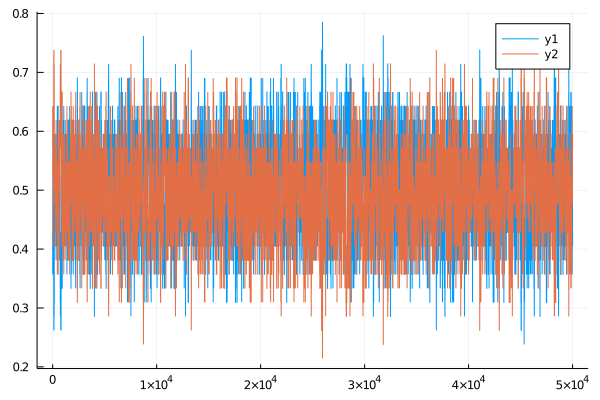

In [58]:
MC_prova = MC(state, 10, 8, 50000)

x = collect(1:MC_prova[3])

    plot(x,MC_prova[1])
    plot!(x,MC_prova[2])